In [1]:
from collections import defaultdict
import numpy as np
from itertools import product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.linear_model import LinearRegression
import math
from functions_for_clustering import *
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn import metrics

In [2]:
df = pd.read_csv('data/test/part_0.csv')
df.head(-1)

,Ticker,index,Date,extremum,-1,-2,-3,-4,-5,-6,...,-275,-276,-277,-278,-279,-280,-281,-282,-283,-284
0,000001.SS,243.0,2021-02-19,1.0,0.979912,0.960347,0.910541,0.841968,0.807106,0.812443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000002.SS,242.0,2021-02-19,1.0,0.979962,0.960403,0.910585,0.842046,0.807224,0.812541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000019.SZ,45.0,2020-04-24,1.0,0.819562,0.655986,0.507589,0.372681,0.246206,0.229342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000020.SZ,95.0,2020-07-10,1.0,0.835148,0.807154,0.720062,0.665630,0.606532,0.552100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000020.SZ,238.0,2021-02-05,0.0,0.018663,0.041991,0.041991,0.041991,0.068429,0.125972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11145,1K2.BE,178.0,2020-11-02,0.0,0.229788,0.275362,0.273881,0.271602,0.270805,0.272628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11146,1K4.F,86.0,2020-06-25,0.0,0.003555,0.003555,0.024882,0.046209,0.167064,0.167064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11147,1K5.F,156.0,2020-10-01,0.0,0.053628,0.053628,0.053628,0.066021,0.008562,0.014196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11148,1K5.F,289.0,2021-04-14,1.0,0.954935,0.909869,0.954935,0.833258,0.842271,0.837765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#extracting data
df_temp = df.drop(labels=['Ticker', 'index', 'Date', 'extremum'], axis=1)

key1 = -15
key2 = min([int(x) for x in df_temp.columns])

df_temp = df_temp.drop(labels=[str(x) for x in list(range(key2,key1))], axis=1)
df_temp = df_temp.loc[df_temp.index < 11150 ]  #тут было 4000 (ну так, чисто на всякий)
df_temp = df_temp.dropna(axis=0)

clustering_data_trended = df_temp.values.tolist()
clustering_data = detrend(clustering_data_trended)


In [17]:
def generate_z_vector_best_new_VERY_BEST(arr, n):
    z_vector = []
    partition = (len(arr)) // n
    for i in range(0,len(arr),partition):
        a = index_element(arr, i, partition, "max")
        b = index_element(arr, i, partition, "min")
        a, b = min(a, b), max(a, b)
        z_vector.append(arr[a])
        z_vector.append(arr[b])
    return z_vector

In [18]:
#creating z-functions for everything
clustering_data_z_optimized = []
for i in clustering_data:
    clustering_data_z_optimized.append(generate_z_vector_best_new_VERY_BEST(i, 5))
print(clustering_data_z_optimized)

[[0.09567757949038935, 0.07850921276866407, -0.035077460817802275, -0.06754305752797063, -0.04250119130435803, -0.02429690823751518, -0.06836134424736895, -0.044626181575073365, 0.022186904656419815, 0.07748790718347554], [0.09562086289557714, 0.07847026750292951, -0.03507038936061713, -0.0674835927114189, -0.042454180206825454, -0.024230932446398623, -0.06840367402873981, -0.04467863703569286, 0.02219222511118868, 0.07750060943817605], [0.28442951512209347, 0.14624578510852304, -0.08627640858842783, -0.18736048802947666, -0.14838190706590673, -0.08926366912613792, -0.03173534528261723, 0.04424635520715059, 0.10346104178693338, 0.05128082244699861], [0.02807154183569749, 0.04587864433807454, -0.004043575378307462, -0.017340640803285234, 0.06026445045704876, 0.059409052203012624, -0.15692072547837413, -0.08934680597585598, 0.024028041321845106, 0.07760489986158836], [0.014904120634208876, 0.0035176995531807156, -0.06591132034172321, -0.07418725047182977, -0.12028803318393781, -0.0539139

In [19]:
clustering_result = get_clustering(clustering_data_z_optimized, 2, 1)
clustering_result

C:\Users\steph\Documents\GitHub\TimeSeries\functions_for_clustering.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  p = [k / (volume(dk[i], m) * n) for i in range(n)]


array([ 197,  197, 2445, ...,  838, 2286, 1973])

In [7]:
sns.set(rc={'figure.figsize':(20,7)})

visualization_data = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data.append(clustering_data[i])

visualization_index = list(range(len(clustering_data[0])))
for i in visualization_data:
    sns.lineplot(y=i, x=visualization_index)

KeyboardInterrupt: 

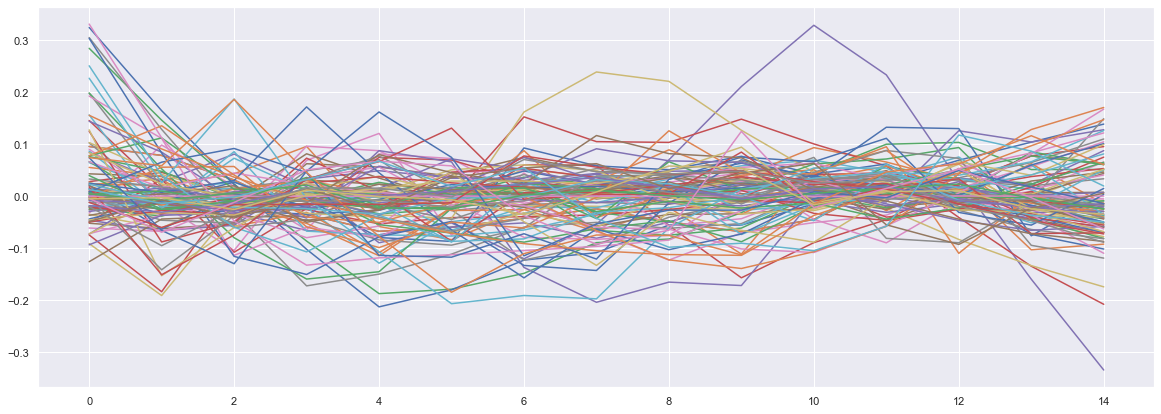

In [14]:
visualization_data = []
for i in range(len(clustering_result)):
    visualization_data.append(clustering_data[i])
    
visualization_index = list(range(len(clustering_data[0])))
for i in visualization_data:
    sns.lineplot(y=i, x=visualization_index)

<AxesSubplot:>

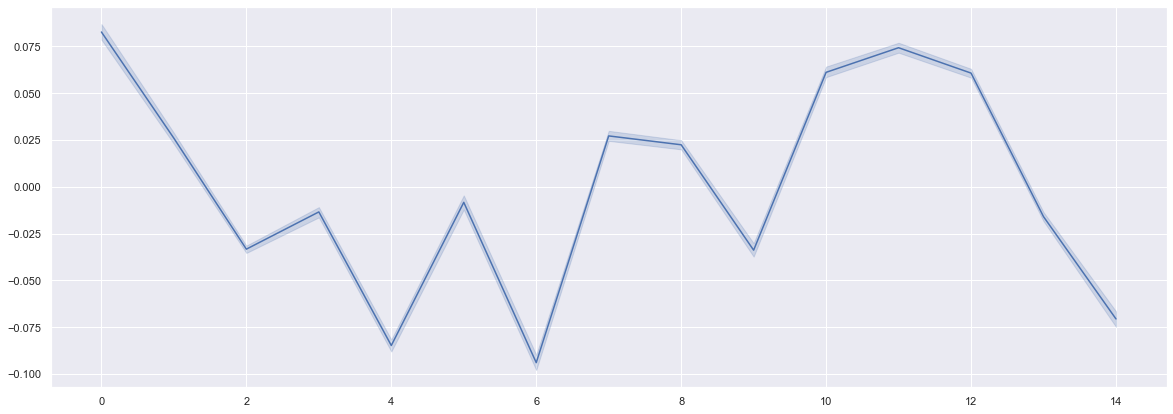

In [42]:
visualization_data_temp = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data_temp.append(clustering_data[i])

visualization_data_flat = np.array(visualization_data_temp).flatten()        
visualization_index_flat = np.array(list(range(len(clustering_data[0])))*len(visualization_data_temp)).flatten()


sns.lineplot(y=visualization_data_flat, x=visualization_index_flat)

<AxesSubplot:>

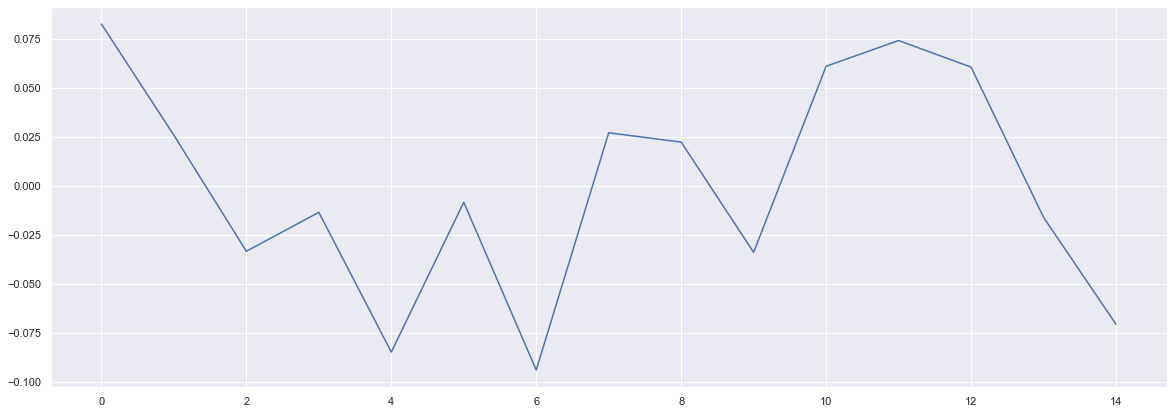

In [66]:
visualization_data = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data.append(clustering_data[i])
        
visualization_index = list(range(len(clustering_data[0])))
    
motif = generate_motif(visualization_data)

sns.lineplot(y=motif, x=visualization_index)

In [13]:
visualization_data = []
for i in range(len(clustering_result)):
    if clustering_result[i] == max(set(clustering_result), key=list(clustering_result).count):
        visualization_data.append(clustering_data[i])
        
neighborhood = []
visualization_index = list(range(len(clustering_data[0])))
visualization_data_flat = np.array(visualization_data).flatten()
visualization_index_flat = np.array(list(range(len(clustering_data[0])))*len(visualization_data)).flatten()
for i in visualization_index:
    neighborhood.append(find_boundaries(visualization_data, visualization_data_flat, i))
neighborhood = np.transpose(neighborhood)
motif2 = [(neighborhood[0][x]+neighborhood[1][x])/2 for x in list(range(len(neighborhood[1])))]
sns.lineplot(y=neighborhood[0], x=visualization_index)
sns.lineplot(y=neighborhood[1], x=visualization_index)
sns.lineplot(y=motif2, x=visualization_index)

KeyboardInterrupt: 

In [12]:
def find_boundaries(visualization_data, visualization_data_flat, time_stamp):
    distance = max(visualization_data_flat) - min(visualization_data_flat)
    #distance2 = math.hypot(max(motif), min(motif))
    #distance3 = abs(max(motif))*math.sqrt(1 + (min(motif)/max(motif))**2)
    scale = np.arange(min(visualization_data_flat),max(visualization_data_flat), distance/100)

    count_on_scale = [0]*len(scale)
    for scale_range_index in range(len(scale)-1):
        for time_series in visualization_data:
            if scale[scale_range_index] < time_series[time_stamp] < scale[scale_range_index + 1]:
                count_on_scale[scale_range_index] += 1

    for i in range(len(count_on_scale)):
        if count_on_scale[i] <= 0.65*max(count_on_scale):
            count_on_scale[i] = 0

    boundaries = []
    index_max = count_on_scale.index(max(count_on_scale))
    for i in range(index_max, 0, -1):
        if count_on_scale[i] == 0:
            boundaries.append(scale[i])
            break
    for i in range(index_max, len(count_on_scale)):
        if count_on_scale[i] == 0:
            boundaries.append(scale[i])
            break
    return boundaries

## Clustering validation starts in 3... 2... 1...

In [20]:
labels = list(clustering_result)
X = clustering_data

metrics.silhouette_score(X, labels, metric='euclidean')

0.03471923526915063

## Сюда будем записывать результаты кластеризации

| Версия z-vector | Кол-во элементов в кластеризации | Silhouette score| Davies-Bouldin score | Вердикт |
| :-: | :-: | :-: | :-: | :-: |
| Старая (min/max) | 4000 (part0) | -0.335068| - | Полная хуйня - quite a lot of samples (series) have been assigned to wrong clusters | 
| Новая (min - max) (среднее) | 4000 (part0) | -0.19188 | - |Уже получше, но все равно отрицательные числа, а это хуево | 
| Новая (min - max) (на каждом участке выбираем min max) | 4000 (part0) | -0.05820 | 1.8262 | Уже получше, но все равно отрицательные числа, а это хуево, а тут еще и близко к 0 / DB_score показывает тоже плохой результат| 
| Новая (min - max) (на каждом участке выбираем min max) | 10000 (part0) | 0.0604 | 1.62692 | Прогресс пошел|
| Новая (min - max) (на каждом участке выбираем min max) | 11500 (part0) | 0.0348 | 1.66053 | А вот тут по какой-то причине стало похуже => надо что-то делать с z-vector'ами |

In [21]:
metrics.davies_bouldin_score(X, labels)

1.6605323120478799